In [1]:
import numpy as np
import scipy.stats as sps
from scipy.spatial import KDTree

from sklearn.base import OutlierMixin, BaseEstimator
from sklearn.utils.validation import validate_data, check_is_fitted

In [8]:
class GPDC(OutlierMixin, BaseEstimator):
    '''
    Generalised Pareto Distribution Classifier for anomaly detection
    '''
    def __init__(self, tail_size: int = 10, alpha: float = 0.01) -> None:
        '''
        :param tail_size: the number of upper order statistics to be used
        :param alpha: default threshold to be used for hypothesis tests
        '''
        self.tail_size = tail_size
        self.alpha = alpha

    def __shapes_and_neg_quantiles(self, neg_distances: np.ndarray) -> np.array:
        thresholds = neg_distances[:, -1]
        tails = neg_distances[:, :-1]
        
        shapes = np.log(-tails).mean(axis=1) - np.log(-thresholds)
        neg_quantiles = -sps.genpareto.ppf(1 - 1 / self.tail_size,
                                           c=shapes,
                                           loc=thresholds,
                                           scale=thresholds * shapes)
        return shapes, neg_quantiles

    def fit(self, X: np.ndarray, y: None = None) -> 'GPDC':
        '''
        :param X: matrix with training points from normal class
        '''
        self.is_fitted_ = True

        X = X if len(X.shape) == 2 else X.reshape((len(X), 1))
        X = validate_data(self, X)
        
        self._kd_tree = KDTree(X)

        # k + 1 upper order statistics
        neg_distances = -self._kd_tree.query(X, self.tail_size + 2)[0][:, 1:]
        shapes, neg_quantiles = self.__shapes_and_neg_quantiles(neg_distances)

        dim = X.shape[-1]
        self._sorted_dimshapes = np.sort(dim * shapes)
        self._sorted_neg_quantiles = np.sort(neg_quantiles)
        return self

    def __quantile(self, sorted_data: np.array, q: float) -> float:
        n = len(sorted_data)
        j = int(q * (n - 1) // 1)
        g = q * (n - 1) % 1
        return (1 - g) * sorted_data[j] + g * sorted_data[j + 1]

    def predict(self, X: np.ndarray, alpha: float | None = None) -> np.array:
        '''
        Returns 1 for normal points and -1 for abnormal ones.
        :param X: matrix with points to test for abnormality
        :param alpha: probability threshold for hypothesis tests
                      (if None, self.alpha is used)
        '''
        check_is_fitted(self)

        X = X if len(X.shape) == 2 else X.reshape((len(X), 1))
        X = validate_data(self, X, reset=False)

        # k + 1 upper order statistics
        neg_distances = -self._kd_tree.query(X, self.tail_size + 1)[0]
        shapes, neg_quantiles = self.__shapes_and_neg_quantiles(neg_distances)

        alpha = alpha or self.alpha
        # Bonferroni's correction for multiple testing
        dimshape_threshold = self.__quantile(self._sorted_dimshapes, 1 - alpha / 2)
        neg_quantile_threshold = self.__quantile(self._sorted_neg_quantiles,
                                                 1 - alpha / 2)

        dim = X.shape[-1]
        result = -np.ones(X.shape[0], dtype=int)
        result[(dim * shapes < dimshape_threshold) &
               (neg_quantiles < neg_quantile_threshold)] = 1
        return result

In [24]:
import typing as tp


class DiscreteGPDC(OutlierMixin, BaseEstimator):
    '''
    GPDC modification to work with discrete distributions.
    '''
    def __init__(self, tail_size: int = 10, alpha: float = 0.01) -> None:
        '''
        :param tail_size: the number of upper order statistics to be used
        :param alpha: default threshold to be used for hypothesis tests
        '''
        self.tail_size = tail_size
        self.alpha = alpha

    def fit(self, X: np.ndarray, y: None = None) -> 'DiscreteGPDC':
        '''
        :param X: matrix with training points from normal class
        '''
        self._is_fitted = True

        X = X if len(X.shape) == 2 else X.reshape((len(X), 1))
        X = validate_data(self, X)

        self._dataset = set(tuple(row) for row in X)
        self._gpdc = GPDC(self.tail_size, self.alpha).fit(np.array(list(self._dataset)))

        return self

    def predict(self, X: np.ndarray, alpha: float | None = None) -> np.array:
        '''
        Returns 1 for normal points and -1 for abnormal ones.
        :param X: matrix with points to test for abnormality
        :param alpha: probability threshold for hypothesis tests
                      (if None, self.alpha is used)
        '''
        check_is_fitted(self)
        
        X = X if len(X.shape) == 2 else X.reshape((len(X), 1))
        X = validate_data(self, X, reset=False)

        result = np.zeros(X.shape[0], dtype=int)
        exact_matches = np.array([tuple(row) in self._dataset for row in X])
        result[exact_matches] = 1

        if (~exact_matches).sum() > 0:
            result[~exact_matches] = self._gpdc.predict(X[~exact_matches])

        return result

In [15]:
from sklearn.utils.estimator_checks import check_estimator

In [25]:
check_estimator(DiscreteGPDC())

/tmp/ipykernel_284685/3983582405.py:17: RuntimeWarning: invalid value encountered in subtract
  shapes = np.log(-tails).mean(axis=1) - np.log(-thresholds)
/tmp/ipykernel_284685/3983582405.py:17: RuntimeWarning: invalid value encountered in subtract
  shapes = np.log(-tails).mean(axis=1) - np.log(-thresholds)
/tmp/ipykernel_284685/3983582405.py:17: RuntimeWarning: invalid value encountered in subtract
  shapes = np.log(-tails).mean(axis=1) - np.log(-thresholds)


AssertionError: 
Arrays are not equal

(shapes (1,), (2,) mismatch)
 ACTUAL: array([1])
 DESIRED: array([-1,  1])

## Проверка на одномерных распределениях

In [26]:
import seaborn as sns

In [27]:
normal_sample = sps.norm.rvs(size=1000, random_state=3)
abnormal_sample = sps.uniform.rvs(size=100, loc=2, scale=1, random_state=3)

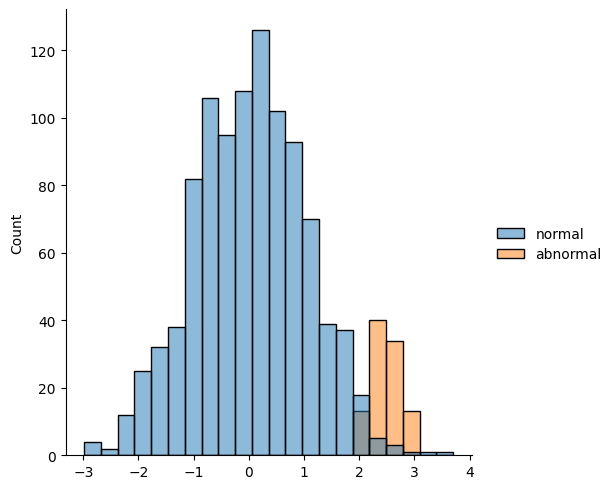

In [28]:
sns.displot({'normal': normal_sample, 'abnormal': abnormal_sample})

Обучим GPDC и получим оценки.

In [29]:
gpdc = DiscreteGPDC().fit(normal_sample[:, np.newaxis])
estims = gpdc.predict(abnormal_sample[:, np.newaxis])

Посмотрим на долю точек, отнесенных к нормальному классу.

In [30]:
print((estims == 1).sum() / len(estims))

0.9


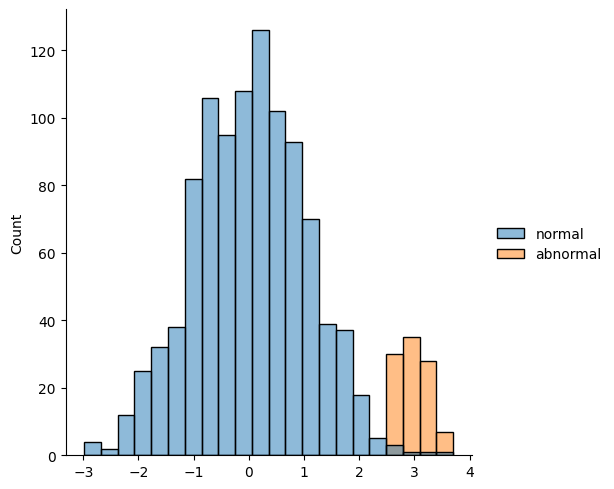

In [31]:
abnormal_sample = sps.uniform.rvs(size=100, loc=2.5, scale=1, random_state=3)
sns.displot({'normal': normal_sample, 'abnormal': abnormal_sample})

In [32]:
estims = gpdc.predict(abnormal_sample[:, np.newaxis])
print((estims == 1).sum() / len(estims))

0.35


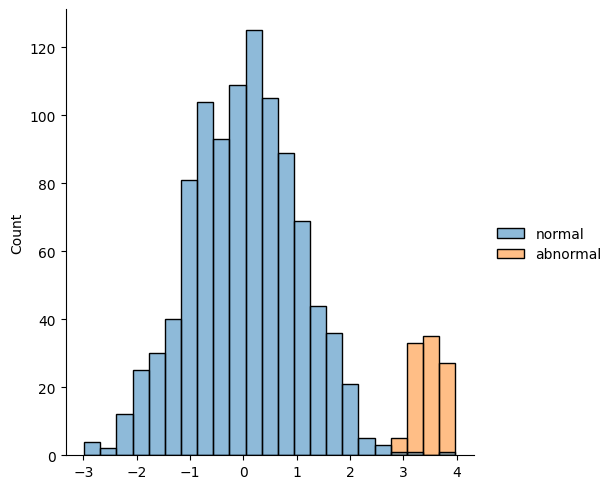

In [33]:
abnormal_sample = sps.uniform.rvs(size=100, loc=3, scale=1, random_state=3)
sns.displot({'normal': normal_sample, 'abnormal': abnormal_sample})

In [34]:
estims = gpdc.predict(abnormal_sample[:, np.newaxis])
print((estims == 1).sum() / len(estims))

0.0


## Проверка с двумерными гауссианами

In [35]:
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

In [36]:
sample = np.vstack([sps.norm.rvs(size=(1000, 2), random_state=3),
                    sps.norm.rvs(size=(1000, 2), loc=(5, 5), random_state=4)])

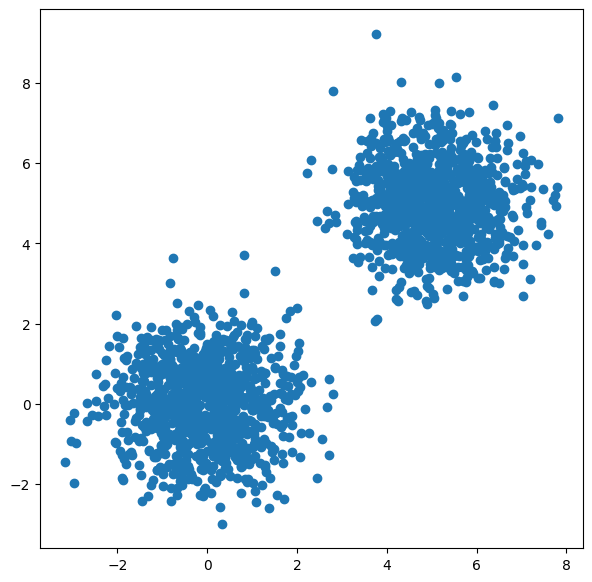

In [37]:
plt.figure(figsize=(7, 7))
plt.scatter(sample[:, 0], sample[:, 1])
plt.show()

Decision boundaries при $\alpha = 0.01$.

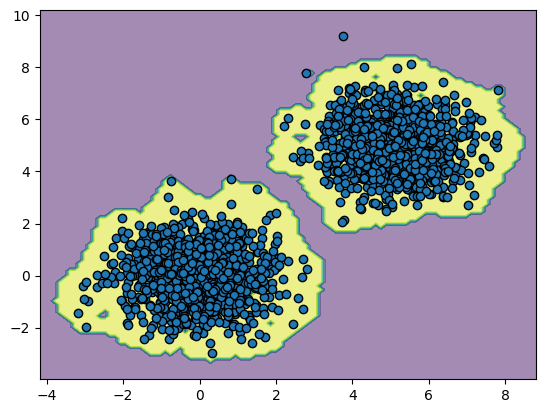

In [38]:
gpdc = DiscreteGPDC().fit(sample)

disp = DecisionBoundaryDisplay.from_estimator(
    gpdc, sample, response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(sample[:, 0], sample[:, 1], edgecolor="k")
plt.show()

Decision boundaries при $\alpha = 0.05$.

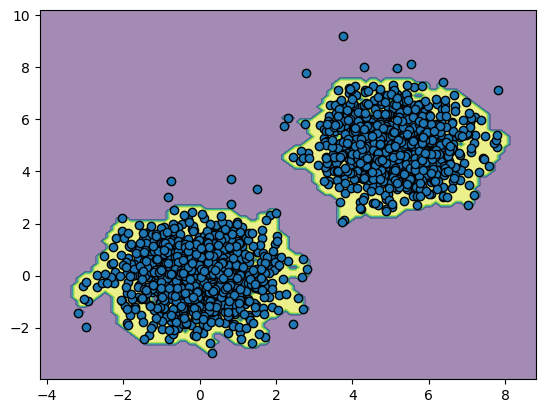

In [39]:
gpdc = DiscreteGPDC(alpha=0.05).fit(sample)

disp = DecisionBoundaryDisplay.from_estimator(
    gpdc, sample, response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(sample[:, 0], sample[:, 1], edgecolor="k")
plt.show()

## OLETTER protocol

In [45]:
from ucimlrepo import fetch_ucirepo

letter_recognition = fetch_ucirepo(id=59)

X = letter_recognition.data.features
y = letter_recognition.data.targets

# metadata
print(letter_recognition.metadata)

# variable information
print(letter_recognition.variables)

{'uci_id': 59, 'name': 'Letter Recognition', 'repository_url': 'https://archive.ics.uci.edu/dataset/59/letter+recognition', 'data_url': 'https://archive.ics.uci.edu/static/public/59/data.csv', 'abstract': 'Database of character image features; try to identify the letter', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 20000, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['lettr'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Thu Sep 28 2023', 'dataset_doi': '10.24432/C5ZP40', 'creators': ['David Slate'], 'intro_paper': None, 'additional_info': {'summary': 'The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet.  The character images were based on 20 different fonts and each letter within these 20 fonts wa

In [46]:
type(X)

pandas.core.frame.DataFrame

In [47]:
type(y)

pandas.core.frame.DataFrame

In [48]:
X.head()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [49]:
y.head()

,lettr
0,T
1,I
2,D
3,N
4,G
